# Curvature Compression: Baseline Tests

In this notebook, we give a guided tour on the advantage of curvature compression for choosing a linear model for manifold data

In [5]:
# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# import open3d as o3d

import sys
# setting path
sys.path.append('../')
from tools.manifold_generator import Manifold
import modules.find_patches_community_detection as find_patches

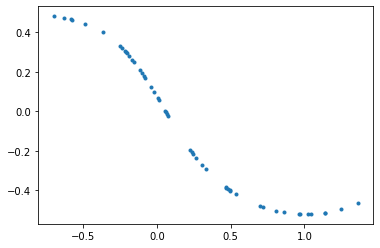

torch.Size([2, 50])


In [56]:
hi = Manifold(D=2, d=1, curvature=1, n_basis=20)
X = hi.generateSample(N=50, uniform=True)
plt.plot(X[0,:], X[1,:],'.')
plt.show()
print(X.shape)

In [54]:
ind, merge_path = find_patches.find_patches_and_merge_path(X, k=5)
print(ind)
print(merge_path)

[{0, 1, 2, 3, 4, 5}, {6, 7, 8, 9, 10, 11}, {16, 17, 12, 13, 14, 15}, {18, 19, 20, 21, 22, 23, 24}]
[[{0}, {1}, {2}, {3}], [{2}, {3}, {0, 1}], [{0, 1}, {2, 3}], [{0, 1, 2, 3}]]


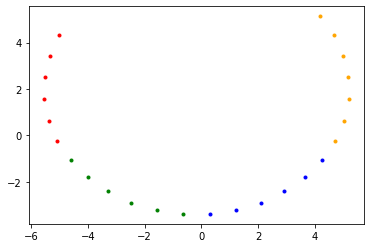

In [55]:
ind1 = np.array([x for x in ind[0]])
plt.plot(X[0,ind1], X[1,ind1], '.', c='r')
ind2 = np.array([x for x in ind[1]])
plt.plot(X[0,ind2], X[1,ind2],'.', c='g')
ind3 = np.array([x for x in ind[2]])
plt.plot(X[0,ind3], X[1,ind3],'.', c='b')
ind4 = np.array([x for x in ind[3]])
plt.plot(X[0,ind4], X[1,ind4],'.', c='orange')
# ind5 = np.array([x for x in ind[4]])
# plt.plot(X[0,ind5], X[1,ind5],'.', c='purple')
plt.show()

In [66]:
hi = Manifold(D=3, d=2, curvature=1, n_basis=20)
X = hi.generateSample(N=50000, uniform=True)

pointclud = X.T.detach().numpy()
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pointclud)
o3d.visualization.draw_geometries([pcd])

# Generate manifold data

In [ ]:
# stochastic gradient descent on MSE error of the training data
# X and the targets Y


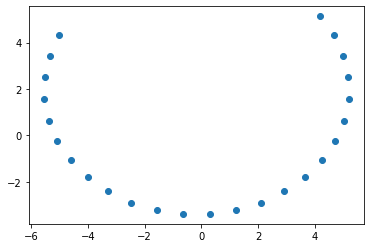

In [51]:
# dimension of data
d = 2
# number of samples
n = 25
# variance of noise
eps2 = 0
# determine if we should randomly rotate
rotate=False


# 2D manifold in 4D space

# sqrt_n = 25
# n = sqrt_n**2

# Z = np.zeros((d,n))
# for i in range(sqrt_n):
# 	for j in range(sqrt_n):
# 		x = (-0.5 + (i+1)/sqrt_n)*2*np.pi
# 		y = (-0.5 + (j+1)/sqrt_n)*2*np.pi
# 		Z[0,j + sqrt_n*i] = x
# 		Z[1,j + sqrt_n*i] = y
# 		Z[2,j + sqrt_n*i] = np.sin(4*x)
# 		Z[3,j + sqrt_n*i] = np.sin(7*y)


# # mean center
# Z = Z - np.mean(Z,axis=1,keepdims=True)
# # global normalization
# Z = Z * n / np.sqrt(np.sum(np.power(Z, 2)))

# plt.scatter(Z[0,:], Z[1,:])
scale=2
Z = np.zeros((d,n))
for i in range(n):
	x = (-0.5 + (i+1)/n)*2*np.pi
	Z[0,i] = x
	# Z[1,i] = scale*np.sin(x)
	Z[1,i] = scale*np.sin(x) + scale/2*np.sin(3*x + 1.5)

Z = np.zeros((d,n))
for i in range(n):
	x = (1.5 - 1.4/2 +1.4*(i+1)/n)*np.pi
	Z[0,i] = np.cos(x)
	# Z[1,i] = scale*np.sin(x)
	Z[1,i] = np.sin(x)

# add noise
Z = Z + eps2*np.random.randn(d, n)


# center and scale
Z_mean_orig = Z.mean(axis=1,keepdims=True)
Z = Z - Z_mean_orig
Z_norm_orig = np.linalg.norm(Z, 'fro')
Z = Z * n / Z_norm_orig

# random rotation, preserves centering and scale
if rotate:
	A = np.random.randn(d,d)
	u,s,vt = np.linalg.svd(A)
	Z = u@Z

# Z = Z[:,8:12]
plt.scatter(Z[0,:], Z[1,:])

# PCA on manifold data

Showing the linear component PCA would choose to eliminate. Note it does not give the proper elimination

[-0.0878512   0.99613361]


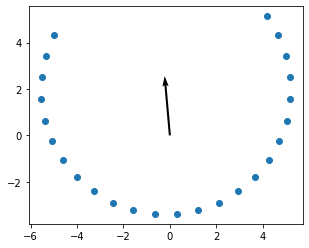

In [5]:
u, s, vt = np.linalg.svd(Z)
u_min = u[:,1]
print(u_min)

# scale to look nice on graph
u_show = u_min * np.min(np.max(np.abs(Z), axis=1))/2

plt.scatter(Z[0,:], Z[1,:])
plt.quiver(0, 0, u_show[0], u_show[1],scale_units='xy', angles='xy',scale=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

We would idealy get a vector in the span of $(0,1)$, since all extraneous curvature is in the $y$-direction. As can be seen, the direction of least variance does not necessarily correspond to the best direction to compress curvature.

# Curvature compression on manifold data

We now test our new proposed method, curvature compression. The function we theoretically want to optimize for is the following:

$$v_* = \argmin_{\|v\|_2 = 1} \max_{x, y \in Z \mid x \ne y} |\langle v, \frac{x-y}{\|x-y\|_2}\rangle|$$
$$= \argmin_{\|v\|_2 = 1} \|\langle v, \frac{x-y}{\|x-y\|_2}\rangle\|_\infty. $$

However, since the $L^\infty$ norm is hard to directly optimize, we settle for a smooth surrogate norm: the $L^4$-norm.

In [42]:
# PyTorch model to optimize our custom loss
class CurvatureElimination(nn.Module):

    def __init__(self, X, u_0):
        super(CurvatureElimination, self).__init__();
        # data
        self.X = X
        # construct edm and gamma weight matrix
        gram = X.T@X
        edm = torch.diag(gram).reshape((n,1))@torch.ones((1,n)) \
                + torch.ones((n,1))@torch.diag(gram).reshape((1,n)) \
                - 2*gram

        edm = torch.sqrt(edm)

        # diagonal weights don't matter, set to 1 as convention
        self.gamma = torch.divide(torch.Tensor([1]),torch.eye(n) + edm)
        # projection vec
        self.u = nn.Parameter(u_0)

    def forward(self):
        U_stacked = torch.ones(self.X.shape)*self.u
        A = (self.X.T @ U_stacked - U_stacked.T @ self.X)*self.gamma
        return 0.5*A.pow(4).sum()

# PyTorch model to optimize our custom loss
class CurvatureEliminationSGD(nn.Module):

    def __init__(self, u_0):
        super(CurvatureEliminationSGD, self).__init__();

        # projection vec
        self.u = nn.Parameter(u_0)

    def forward(self, X_batch):
        # compute injectivity loss on minibatch
        d, n_batch = X_batch.shape
        edm_batch = torch.cdist(X_batch.T, X_batch.T)
        gamma_batch = torch.divide(torch.Tensor([1]),torch.eye(n_batch) + edm_batch)
        U_stacked = torch.ones(X_batch.shape)*self.u
        A = (X_batch.T @ U_stacked - U_stacked.T @ X_batch)*gamma_batch
        return 0.5*A.pow(4).mean()

# PyTorch model to optimize our custom loss
class CurvatureEliminationPieces(nn.Module):

    def __init__(self, X, u_0, u_02, u_03):
        super(CurvatureEliminationPieces, self).__init__();
        # data
        self.X = X
        # construct edm and gamma weight matrix
        gram = X.T@X
        edm = torch.diag(gram).reshape((n,1))@torch.ones((1,n)) \
                + torch.ones((n,1))@torch.diag(gram).reshape((1,n)) \
                - 2*gram

        edm = torch.sqrt(edm)

        # diagonal weights don't matter, set to 1 as convention
        self.gamma = torch.divide(torch.Tensor([1]),torch.eye(n) + edm)
        # projection vec
        self.u = nn.Parameter(u_0)
        self.u2 = nn.Parameter(u_02)
        self.u3 = nn.Parameter(u_03)

    def forward(self):
        U_stacked = torch.ones(self.X[:,:13].shape)*self.u
        A = (self.X[:,:13].T @ U_stacked - U_stacked.T @ self.X[:,:13])*self.gamma[:13,:13]
        U_stacked2 = torch.ones(self.X[:,7:16].shape)*self.u2
        A2 = (self.X[:,7:16].T @ U_stacked2 - U_stacked2.T @ self.X[:,7:16])*self.gamma[7:16,7:16]
        U_stacked3 = torch.ones(self.X[:,13:].shape)*self.u3
        A3 = (self.X[:,13:].T @ U_stacked3 - U_stacked3.T @ self.X[:,13:])*self.gamma[13:,13:]
        return 0.5*(A.pow(4).sum() + A2.pow(4).sum() + A3.pow(4).sum()) - 2*((self.u.T@self.u2).pow(2) + (self.u2.T@self.u3).pow(2))

In [20]:
loader = data.DataLoader(dataset=data.TensorDataset(X.T), batch_size=12, shuffle=True)
# sample batch from loader
X_batch = next(iter(loader))[0].T
print(X.shape)
print(X_batch.shape)

torch.Size([2, 500])
torch.Size([2, 12])


# SGD tests

In [54]:
d, n = X.shape
batch_size =10
u_0 = torch.randn(d,1)
u_0 = u_0 / torch.norm(u_0, p=2, dim=0)

cc = CurvatureEliminationSGD(u_0)
loader = data.DataLoader(dataset=data.TensorDataset(X.T), batch_size=12, shuffle=True)

opt = optim.SGD(cc.parameters(), lr=0.01)

for i in range(10000):
	cc.zero_grad()
	# forward call of LinFlow
	X_batch = next(iter(loader))[0].T
	loss = cc(X_batch)

	loss.backward()

	# compute Riemannian gradient
	egrad = cc.u.grad.detach()
	base = cc.u.data.detach()
	base = base / torch.sqrt(base.pow(2).sum())
	rgrad = egrad - base@base.t()@egrad
	# GD step
	opt.step()
	# renormalization step
	with torch.no_grad():
		cc.u.data = cc.u.data / torch.sqrt((cc.u.data).pow(2).sum());

	# determine if we have converged
	gradnorm = torch.linalg.norm(rgrad)
	if gradnorm < 5e-5:
		# print(f'converged in {i} steps!')
		# break
		pass
	if i%100 == 0:
		print(f'g step {i}: {gradnorm}')

print('done!')

g step 0: 0.016552096232771873
g step 100: 0.03008676879107952
g step 200: 0.046776991337537766
g step 300: 0.05334431305527687
g step 400: 0.057042889297008514
g step 500: 0.021112091839313507
g step 600: 0.03477724269032478
g step 700: 0.010997059755027294
g step 800: 0.0019211889011785388
g step 900: 0.005317394621670246
g step 1000: 0.0026451428420841694
g step 1100: 0.003939591348171234
g step 1200: 0.006208642385900021
g step 1300: 0.0070342449471354485
g step 1400: 0.005849484819918871
g step 1500: 0.02514476887881756
g step 1600: 0.0040291426703333855
g step 1700: 0.0015502816531807184
g step 1800: 0.011169602163136005
g step 1900: 0.0013696800451725721
g step 2000: 0.010322331450879574
g step 2100: 0.006969420239329338
g step 2200: 0.0058410814963281155
g step 2300: 0.00986667349934578
g step 2400: 0.0031435585115104914
g step 2500: 0.0014721740735694766
g step 2600: 0.012260540388524532
g step 2700: 0.0024457862600684166
g step 2800: 0.016621556133031845
g step 2900: 0.031186

In [24]:
# optimize via projected gradient descent

u_0 = torch.randn((d,1))
u_0 = u_0 / torch.sqrt(u_0.pow(2).sum())
u_02 = torch.randn((d,1))
u_02 = u_02 / torch.sqrt(u_02.pow(2).sum())
u_03 = torch.randn((d,1))
u_03 = u_03 / torch.sqrt(u_03.pow(2).sum())
X = torch.Tensor(Z)

cc = CurvatureEliminationPieces(X, u_0, u_02, u_03)
opt = optim.SGD(cc.parameters(), lr=0.001)

for i in range(1000):
	cc.zero_grad()
	# forward call of LinFlow
	loss = cc()

	loss.backward()

	# compute Riemannian gradient
	egrad = cc.u.grad.detach()
	base = cc.u.data.detach()
	base = base / torch.sqrt(base.pow(2).sum())
	rgrad = egrad - base@base.t()@egrad
	# GD step
	opt.step()
	# renormalization step
	with torch.no_grad():
		cc.u.data = cc.u.data / torch.sqrt((cc.u.data).pow(2).sum());
		cc.u2.data = cc.u2.data / torch.sqrt((cc.u2.data).pow(2).sum());
		cc.u3.data = cc.u3.data / torch.sqrt((cc.u3.data).pow(2).sum());

	# determine if we have converged
	gradnorm = torch.linalg.norm(rgrad)
	if gradnorm < 5e-5:
		# print(f'converged in {i} steps!')
		# break
		pass
	if i%100 == 0:
		print(f'g step {i}: {gradnorm}')

print('done!')

NameError: name 'Z' is not defined

In [53]:
# optimize via projected gradient descent

u_0 = torch.randn((d,1))
u_0 = u_0 / torch.sqrt(u_0.pow(2).sum())
X = torch.Tensor(Z)

cc = CurvatureEliminationPieces(X, u_0, u_02, u_03)
opt = optim.SGD(cc.parameters(), lr=0.001)

for i in range(1000):
	cc.zero_grad()
	# forward call of LinFlow
	loss = cc()

	loss.backward()

	# compute Riemannian gradient
	egrad = cc.u.grad.detach()
	base = cc.u.data.detach()
	base = base / torch.sqrt(base.pow(2).sum())
	rgrad = egrad - base@base.t()@egrad
	# GD step
	opt.step()
	# renormalization step
	with torch.no_grad():
		cc.u.data = cc.u.data / torch.sqrt((cc.u.data).pow(2).sum());
		cc.u2.data = cc.u2.data / torch.sqrt((cc.u2.data).pow(2).sum());
		cc.u3.data = cc.u3.data / torch.sqrt((cc.u3.data).pow(2).sum());

	# determine if we have converged
	gradnorm = torch.linalg.norm(rgrad)
	if gradnorm < 5e-5:
		# print(f'converged in {i} steps!')
		# break
		pass
	if i%100 == 0:
		print(f'g step {i}: {gradnorm}')

print('done!')

g step 0: 48.64806365966797
g step 100: 0.010759027674794197
g step 200: 0.00017109086911659688
g step 300: 2.117500662279781e-05
g step 400: 2.5177723728120327e-05
g step 500: 3.43852161677205e-06
g step 600: 3.43852161677205e-06
g step 700: 3.43852161677205e-06
g step 800: 3.43852161677205e-06
g step 900: 3.43852161677205e-06
done!


learned compression direction: [[ 0.04923584 -0.9987872 ]]


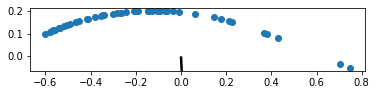

In [55]:
# show learned compression direction
u_cc = cc.u.data.detach().clone().numpy()

print(f'learned compression direction: {u_cc.T}')
# scale to look nice on graph
# u_show = u_cc * np.min(np.max(torch.abs(X), axis=1))/2
u_show = u_cc

plt.scatter(X[0,:], X[1,:])
# plt.scatter(Z[0,3], Z[1,3],c='r')
# plt.scatter(Z[0,11], Z[1,11],c='r')
# plt.scatter(Z[0,18], Z[1,18],c='r')
plt.quiver(0, 0, u_show[0], u_show[1],scale_units='xy', angles='xy',scale=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [32]:
maxval = 0
for i in range(8):
	for j in range(8):
		if i != j:
			if np.abs(u_cc.T@(Z[:,i]-Z[:,j]) / np.linalg.norm(Z[:,i]-Z[:,j]))  > maxval:
				maxval = u_cc.T@(Z[:,i]-Z[:,j])/ np.linalg.norm(Z[:,i]-Z[:,j])
		

print(f'max correlation from computed vec:{maxval}')

u_new = np.zeros((2,1))
u_new[1] = 1
u_new[0] = 0
u_new = u_new / np.linalg.norm(u_new)
maxval = 0
for i in range(8):
	for j in range(8):
		if i != j:
			if np.abs(u_new.T@(Z[:,i]-Z[:,j])/ np.linalg.norm(Z[:,i]-Z[:,j])) > maxval:
				maxval = u_new.T@(Z[:,i]-Z[:,j])/ np.linalg.norm(Z[:,i]-Z[:,j])
		

print(f'max correlation from (0,1):{maxval}')

U_stacked = np.ones(Z.shape)*u_cc
A = (Z.T @ U_stacked - U_stacked.T @ Z)*cc.gamma.detach().cpu().numpy()
print(0.5*np.sum(np.power(np.abs(A),4)))

U_stacked = np.ones(Z.shape)*u_new
A = (Z.T @ U_stacked - U_stacked.T @ Z)*cc.gamma.detach().cpu().numpy()
print(0.5*np.sum(np.power(np.abs(A),4)))

max correlation from computed vec:[0.86410201]
max correlation from (0,1):[0.99992104]
126.539462985678
91.92093872057539


# Step 2
find global positioning for each piece

In [27]:
# softmax parameter
gamma = 0.5

# PyTorch model to optimize our custom loss
class AlignmentPieces(nn.Module):

    def __init__(self, X, u, u2, u3, alpha_0):
        super(AlignmentPieces, self).__init__();
        self.X = X	

        # get softmax coefficients
        v1 = X[:,[8]]
        v2 = X[:,[12]]
        v3 = X[:,[16]]

        # vectors of square distances
        dists1 = (X-v1).pow(2).sum(axis=0)
        dists2 = (X-v2).pow(2).sum(axis=0)
        dists3 = (X-v3).pow(2).sum(axis=0)

        dists_vec = torch.vstack((dists1,dists2,dists3))
        self.probs = nn.Softmax(dim=0)(-gamma*dists_vec)

        # projection vec
        self.u = u
        # self.alpha = nn.Parameter(alpha_0)
        self.u2 = u2
        self.alpha2 = nn.Parameter(alpha_0.clone())
        self.u3 = u3
        self.alpha3 = nn.Parameter(alpha_0.clone())

    def forward(self):
        # to eliminate redunancy, enforce first alpha to be 0
        Xproj1 = self.X - self.u@self.u.T@self.X
        Xproj2 = self.X - self.u2@self.u2.T@self.X + self.alpha2*self.u2
        Xproj3 = self.X - self.u3@self.u3.T@self.X + self.alpha3*self.u3

        E_Xproj = self.probs[[0],:]*Xproj1 + self.probs[[1],:]*Xproj2 + self.probs[[2],:]*Xproj3
        Var_X = self.probs[[0],:]*(Xproj1 - E_Xproj).pow(2).sum(axis=0) + self.probs[[1],:]*(Xproj2 - E_Xproj).pow(2).sum(axis=0) + self.probs[[2],:]*(Xproj3 - E_Xproj).pow(2).sum(axis=0)
        return Var_X.sum()
        

In [28]:
align = AlignmentPieces(torch.Tensor(Z), cc.u.data, cc.u2.data, cc.u3.data, torch.Tensor([1]))
opt = optim.SGD(align.parameters(), lr=0.1)

for i in range(50000):
	align.zero_grad()
	# forward call of LinFlow
	loss = align()
	loss.backward()

	# GD step
	opt.step()

	# determine if we have converged
	gradnorm = torch.sqrt(align.alpha2.grad.detach().pow(2) + align.alpha3.grad.detach().pow(2))
	if gradnorm < 5e-5:
		# print(f'converged in {i} steps!')
		# break
		pass
	if i%1000 == 0:
		# print(f'g step {i}: {gradnorm}')
		print(f'data {align.alpha2.data}, {align.alpha3.data}. loss {loss}')
		# print(align.alpha2.data)
		# print(align.alpha3.data)

print('done!')

data tensor([0.7168]), tensor([0.7919]). loss 9.552173614501953
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.759867429733276

KeyboardInterrupt: 

In [29]:
v1 = Z[:,[4]]
v2 = Z[:,[12]]
v3 = Z[:,[20]]

for i in range(n):
	dists = np.zeros(3)
	dists[0] = np.linalg.norm(Z[:,i] - v1)
	dists[1] = np.linalg.norm(Z[:,i] - v2)
	dists[2] = np.linalg.norm(Z[:,i] - v3)
	if np.argmin(dists) == 0:
		print(i)
		

# plot

[0.9160609 0.0542517 0.0296874]
[0.93651615 0.04541842 0.01806543]
[0.95012564 0.03862679 0.01124757]
[0.95927607 0.03351178 0.00721215]
[0.96546808 0.02974424 0.00478769]
[0.92543584 0.0664506  0.00811357]
[0.84254679 0.14390616 0.01354705]
[0.69333333 0.2855586  0.02110807]
[0.48562011 0.48562011 0.02875979]
[0.28202854 0.68476239 0.03320907]
[0.14098686 0.82545477 0.03355837]
[0.06487947 0.90355532 0.03156521]
[0.02902    0.94196001 0.02902   ]
[0.03156521 0.90355532 0.06487947]
[0.03355837 0.82545477 0.14098686]
[0.03320907 0.68476239 0.28202854]
[0.02875979 0.48562011 0.48562011]
[0.02110807 0.2855586  0.69333333]
[0.01354705 0.14390616 0.84254679]
[0.00811357 0.0664506  0.92543584]
[0.00478769 0.02974424 0.96546808]
[0.00721215 0.03351178 0.95927607]
[0.01124757 0.03862679 0.95012564]
[0.01806543 0.04541842 0.93651615]
[0.0296874 0.0542517 0.9160609]


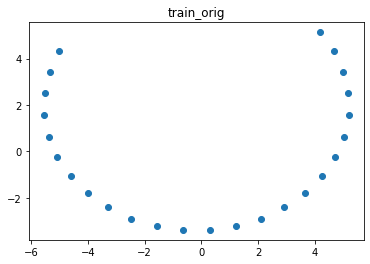

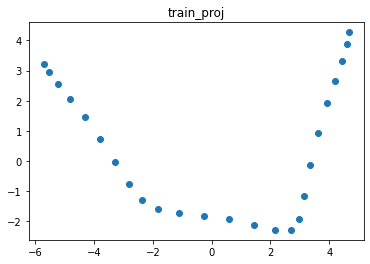

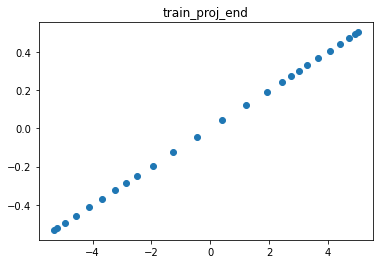

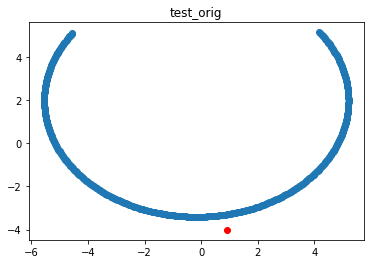

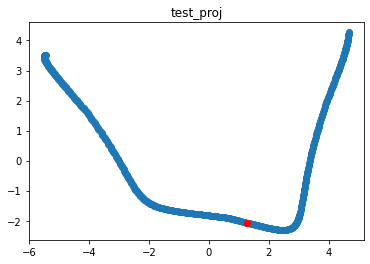

In [53]:
u1 = cc.u.detach().clone().cpu().numpy()
A1_proj = np.eye(d) - u1@u1.T
u2 = cc.u2.detach().clone().cpu().numpy()
A2_proj = np.eye(d) - u2@u2.T
u3 = cc.u3.detach().clone().cpu().numpy()
A3_proj = np.eye(d) - u3@u3.T

alpha2 = align.alpha2.detach().clone().cpu().numpy()
alpha3 = align.alpha3.detach().clone().cpu().numpy()

Z_new = np.zeros(Z.shape)
for i in range(n):
	z_vec = Z[:,[i]]
	# compute local components
	proj1 = A1_proj@z_vec + 2.3*u1
	proj2 = A2_proj@z_vec + alpha2*u2
	proj3 = A3_proj@z_vec + alpha3*u3
	# softmax
	dist1 = np.linalg.norm(z_vec - v1)
	dist2 = np.linalg.norm(z_vec - v2)
	dist3 = np.linalg.norm(z_vec - v3)

	probs = np.array([np.exp(-gamma*dist1), np.exp(-gamma*dist2), np.exp(-gamma*dist3)])
	probs = probs/probs.sum()
	print(probs)

	z_new = proj1*probs[0] + proj2*probs[1] + proj3*probs[2]
	Z_new[:,[i]] = z_new


plt.scatter(Z[0,:], Z[1,:])
plt.title('train_orig')
plt.show()
plt.scatter(Z_new[0,:], Z_new[1,:])
plt.title('train_proj')
plt.show()

u_proj = np.array([-0.1,1]).reshape((2,1))
u_proj = u_proj / np.linalg.norm(u_proj)

Z_new_new = Z_new - u_proj@u_proj.T@Z_new
plt.scatter(Z_new_new[0,:], Z_new_new[1,:])
plt.title('train_proj_end')
plt.show()

scale=2
n_test = 500
Z_test = np.zeros((d,n_test))
for i in range(n_test):
	x = (1.5 - 1.4/2 +1.4*(i+1)/n_test)*np.pi
	Z_test[0,i] = np.cos(x)
	# Z[1,i] = scale*np.sin(x)
	Z_test[1,i] = np.sin(x)


# center and scale (TO ORIGINAL TRAIN DATA)
Z_test = Z_test - Z_mean_orig
Z_test = Z_test * n / Z_norm_orig

# see what mapping is like on test data
test_point = Z_test[:,[250]] + 1*np.random.randn(2,1)

plt.scatter(Z_test[0,:], Z_test[1,:])
plt.scatter(test_point[0,:], test_point[1,:], color='red')
plt.title('test_orig')
plt.show()



for i in range(n_test):
	z_vec = Z_test[:,[i]]
	# compute local components
	proj1 = A1_proj@z_vec + 2*u1
	proj2 = A2_proj@z_vec + alpha2*u2
	proj3 = A3_proj@z_vec + alpha3*u3
	# softmax
	dist1 = np.linalg.norm(z_vec - v1)
	dist2 = np.linalg.norm(z_vec - v2)
	dist3 = np.linalg.norm(z_vec - v3)

	probs = np.array([np.exp(-gamma*dist1), np.exp(-gamma*dist2), np.exp(-gamma*dist3)])
	probs = probs/probs.sum()

	z_new = proj1*probs[0] + proj2*probs[1] + proj3*probs[2]
	Z_test[:,[i]] = z_new



# test point map
z_vec = test_point
# compute local components
proj1 = A1_proj@z_vec + 2.3*u1
proj2 = A2_proj@z_vec + alpha2*u2
proj3 = A3_proj@z_vec + alpha3*u3
# softmax
dist1 = np.linalg.norm(z_vec - v1)
dist2 = np.linalg.norm(z_vec - v2)
dist3 = np.linalg.norm(z_vec - v3)

probs = np.array([np.exp(-gamma*dist1), np.exp(-gamma*dist2), np.exp(-gamma*dist3)])
probs = probs/probs.sum()

z_new = proj1*probs[0] + proj2*probs[1] + proj3*probs[2]
f_test = z_new

plt.scatter(Z_test[0,:], Z_test[1,:])
plt.scatter(f_test[0,:], f_test[1,:], color='red')
plt.title('test_proj')
plt.show()


	

# Stochastic GD for learning injective projectors